In [ ]:
# @title Loading data

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab_Notebooks/lorentz_long_x.csv'

import pandas as pd
import numpy as np

data = pd.read_csv(file_path)
data = np.array(data)

Mounted at /content/drive


In [ ]:
# @title Loading optuna
import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import networkx as nx
import csv

!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.8 MB/s eta 0:00:00


Data length: 1048575


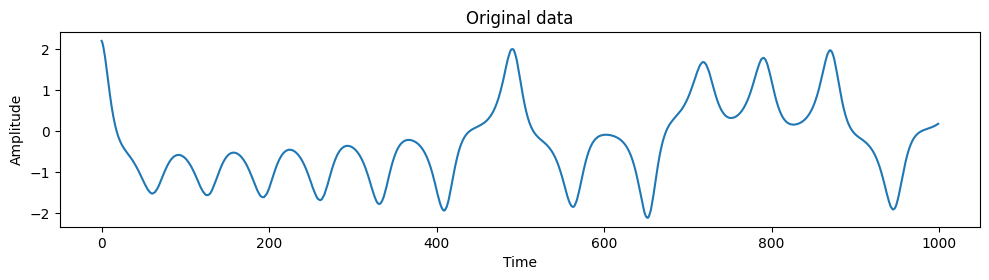

In [ ]:
# @title Data reshaping

import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import datetime
import networkx as nx
import csv


# find missing values
nan_indices = np.where(np.isnan(data))

# delete missing values
data = np.delete(data, nan_indices)

# average and standard deviation
mean_value = np.mean(data)
std_dev = np.std(data)

# Standardization
data = (data - mean_value) / std_dev


print('Data length:',data.size)

#######
# Visualization

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(data[:1000])
plt.title('Original data')
plt.xlabel('Time')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()

In [ ]:
# @title Definition of Reservoir computing (without ``Class" setting!!)

####################
#input weight matrix
####################

def input_matrix(N_x,seed_value,input_scale,dim):

# Separate integer and decimal portions
    seed_int_low = int(np.floor(seed_value))
    seed_int_high = int(np.ceil(seed_value))
    fraction = seed_value - seed_int_low

# Random number generation for integer part
    np.random.seed(seed_int_low)
    random_matrix_low = np.random.uniform(-input_scale, input_scale, (N_x, dim))
    np.random.seed(seed_int_high)
    random_matrix_high = np.random.uniform(-input_scale, input_scale, (N_x, dim))

# Linear interpolation allows random seed values to correspond continuously to the matrix
    interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

    return interpolated_matrix

##############################
# Recurrent weight matrix
##############################

def recurrent_matrix(N_x, density, rho,seed_value):

        m = int(N_x*(N_x-1)*density/2)  # Setting the number of non-zero components


# Separate random seed value into integer and decimal portions
        seed_int_low = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction = seed_value - seed_int_low

# Graph generation based on integer parts
        graph_low =  nx.gnm_random_graph(N_x, m, seed_int_low)
        graph_high =  nx.gnm_random_graph(N_x, m, seed_int_high)

# Get Edge List
        edges_low = set(graph_low.edges())
        edges_high = set(graph_high.edges())

# Separate common edges from different edges
        common_edges = edges_low & edges_high
        only_low_edges = edges_low - edges_high
        only_high_edges = edges_high - edges_low

# Edge interpolation
        num_only_low_edges = len(only_low_edges)
        num_only_high_edges = len(only_high_edges)

        num_edges_to_add_from_high = round(fraction * num_only_high_edges)
        num_edges_to_remove_from_low =round(fraction * num_only_low_edges)

# Building New Edge Sets
        interpolated_edges = list(common_edges)
        interpolated_edges += list(only_low_edges)[:(num_only_low_edges - num_edges_to_remove_from_low)]
        interpolated_edges += list(only_high_edges)[:num_edges_to_add_from_high]

# Generate a new interpolation matrix (only about nonzero positions)
        interpolated_graph = nx.Graph()
        interpolated_graph.add_nodes_from(range(N_x))
        interpolated_graph.add_edges_from(interpolated_edges)

        interpolated_matrix = nx.to_numpy_array(interpolated_graph)
        W = np.asarray(interpolated_matrix)


# Determine each components on each edges

# Separate integer and decimal portions
        seed_int_low = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction = seed_value - seed_int_low

# Generate nonzero elements as random numbers following a uniform distribution
        rec_scale = 1.0

# Random number generation based on integer part
        np.random.seed(seed_int_low)
        random_matrix_low = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))
        np.random.seed(seed_int_high)
        random_matrix_high = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))

# Linear interpolation allows random seed values and matrices to correspond continuously
        interpolated_matrix_value = (1 - fraction) * random_matrix_low + fraction * random_matrix_high
        W *= interpolated_matrix_value

        # Calculation of spectral radius
        eigv_list = np.linalg.eigh(W)[0]
        sp_radius = np.max(np.abs(eigv_list))

        # Scaling to a specified spectral radius rho
        W *= rho / sp_radius
        return W

#############################
# reservoir state vector
#############################

def Reservoir(x_in,x,W,alpha,bias_scale):

        Wbias = np.ones(len(x_in))
        Wbias = Wbias * bias_scale

        x = (1.0 - alpha) * x \
                 + alpha * np.tanh(np.dot(W, x)+Wbias \
                 + x_in)
        return x

############################
#Ridge Regression and  Output Weight Matrix
############################

def Ridge(d, x, X_XT,D_XT):

        x = np.reshape(x, (-1, 1))
        d = np.reshape(d, (-1, 1))
        X_XT += np.dot(x, np.transpose(x))
        D_XT += np.dot(d, np.transpose(x))
        return X_XT, D_XT

def get_Wout_opt(X_XT,D_XT,N_x,beta):

        Wout_opt = np.linalg.solve((X_XT + beta * np.identity(N_x)).T, D_XT.T)
        Wout_opt=Wout_opt.T

        return Wout_opt

###################
#Definition of batch learning (convexity)
###################

def train(train_U,train_D, x, T_train,Win,W,N_x,dim,alpha,discard_len,bias_scale):

    x = np.zeros(N_x)
    X_XT = np.zeros((N_x, N_x))
    D_XT = np.zeros((dim, N_x))

    for n in range(T_train):

            # reservoir state vector
        x = Reservoir(np.dot(Win,train_U[n,:]),x,W,alpha,bias_scale)

            # teacher data
        d = train_D[n,:]


        if n > discard_len:  # discard the first part of the data
            X_XT, D_XT = Ridge(d, x, X_XT, D_XT)

    return X_XT, D_XT,x


########################
#induction formula for creating estimated data
########################

def run(test_U,x,Win,W,Wout,alpha,T_test,bias_scale):


    Y_pred = []
    y = test_U[0,:]


    for n in range(T_test):

        x = Reservoir(np.dot(Win,y),x,W,alpha,bias_scale)
        y_pred = np.dot(Wout, x)
        Y_pred.append(y_pred)
        y = y_pred

    return np.array(Y_pred)

#######################
#Definition of autocorrelation
#######################

def correlation(data1_in, data2_in):

    mean1 = np.mean(data1_in[:])
    mean2 = np.mean(data2_in[:])
    numerator = np.sum((data1_in[:] - mean1) * (data2_in[:] - mean2))
    denominator = np.sqrt(np.sum((data1_in[:] - mean1) ** 2)) * np.sqrt(np.sum((data2_in[:] - mean2) ** 2))

    return numerator / denominator

In [ ]:
# @title Hyperparameter: Bayesian optimization for Reservoir

n_trials    = 100   # Number of times to test with optuna (generate autocorrelation for this number of times)
#Repeat trials until lag and dim become stable

T_train     = 1500 # Training period
T_test      = 100  # Forecast period
test_num    = 40   # Number of times for one test (to get one autocorrelation)
discard_len = 10   # Number of steps not learned at the beginning (not important)

Node        = 70  # Reservoir Node

In [ ]:
# @title Implementation of Bayesian optimization of Reservoir

%%time

from optuna.trial import FrozenTrial
from optuna.trial import TrialState
from datetime import datetime
import os

print(len(data))

################
#We can load (in csv file) and reuse the past trials

file_path = 'reservoir.csv'
past_trials = []
if os.path.exists(file_path):


# Import data from CSV files

   with open(file_path, mode='r', newline='') as file:
       reader = csv.DictReader(file)
       for row in reader:
        # Data processing and incorporation into past_trials
           trial_data = {
               'value': float(row['value']),
               'params': {
                   'lag': int(row['lag']),
                   'dim': int(row['dim']),
                   'N_x': int(row['N_x']),
                   'beta': float(row['beta']),
                   'density': float(row['density']),
                   'input_scale': float(row['input_scale']),
                   'rho': float(row['rho']),
                   'alpha': float(row['alpha']),
                   'seed_value': float(row['seed_value']),
                   'bias_scale': float(row['bias_scale'])
               }
           }
           past_trials.append(trial_data)




# Creating an Optuna Study
study = optuna.create_study(direction="maximize")


###############


# Add past attempts to study
for trial in past_trials:

    if 'value' not in trial:
        print(f"Skipping trial as it does not contain 'value': {trial}")
        continue

    try:
          value = float(trial['value'])
    except ValueError as e:
          print(f"Error converting trial value to float: {e}")
          continue  # Proceed to the next TRIAL


#####

    frozen_trial = FrozenTrial(
        number=study._storage.get_n_trials(study._study_id),
        state=TrialState.COMPLETE,
        value=trial['value'],
        datetime_start=datetime.now(),
        datetime_complete=datetime.now(),
        params=trial['params'],
        distributions={
            'lag': optuna.distributions.IntUniformDistribution(3, 10),
            'dim': optuna.distributions.IntUniformDistribution(3, 15),
            'N_x': optuna.distributions.IntUniformDistribution(Node, Node),  #Initially fixed here
            'beta': optuna.distributions.FloatDistribution(0.01, 0.01),
           'density': optuna.distributions.FloatDistribution(0.001, 1),
            'input_scale': optuna.distributions.FloatDistribution(0, 1),
            'rho': optuna.distributions.FloatDistribution(0, 0.98),
            'alpha': optuna.distributions.FloatDistribution(0, 1),
            'seed_value': optuna.distributions.FloatDistribution(0, 100),
            'bias_scale': optuna.distributions.FloatDistribution(-1, 1)
        },
        user_attrs={},
        system_attrs={},
        intermediate_values={},
        trial_id=study._storage.create_new_trial(study._study_id)
    )
    study.add_trial(frozen_trial)

# Objective Function Definition
def objective(trial):
    lag = trial.suggest_int("lag", 3, 10)
    dim = trial.suggest_int("dim", 3, 15)
    N_x = trial.suggest_int("N_x", Node, Node)                #Initially fixed here
    beta = trial.suggest_float("beta", 0.01, 0.01)
    density = trial.suggest_float("density", 0.001, 1)
    input_scale = trial.suggest_float("input_scale", 0, 1)
    rho = trial.suggest_float("rho", 0, 0.98)
    alpha = trial.suggest_float("alpha", 0, 1)
    seed_value = trial.suggest_float("seed_value", 0, 100)
    bias_scale = trial.suggest_float("bias_scale", -1, 1)

###############

    T_0 = T_train + lag * dim
###############
#Initialization of estimated data

    data_delay = np.zeros((T_train+T_test+1,dim,test_num), dtype=float)
    test_Y = np.zeros((T_test,test_num))
    test_D = np.zeros((T_test,test_num))
    tentative_test_Y=np.zeros((T_test,dim,test_num))
    data_delay_train = np.zeros((T_train+1,dim,test_num), dtype=float)

###############
#Fix input and recurrent weight matrices

    Win= input_matrix(N_x,seed_value,input_scale,dim)
    W = recurrent_matrix(N_x, density, rho,seed_value)



###############
#Convert data to a delay coordinate system

    for t in range(test_num):
        for i in range(dim):

            data_delay_train[:,i,t] = data[T_0-T_train-i*lag+t:T_0-i*lag+1+t] # i*lag Step-delayed time series


# Initialization of training data

        train_U = np.zeros((T_train,dim), dtype=float)
        train_D = np.zeros((T_train,dim), dtype=float)

#Input/output of training data

        train_U = data_delay_train[:T_train,:,t]
        train_D = data_delay_train[1:T_train+1,:,t]

##The last time data of the training data output must overlap with the test data!

#Ridge
        X_XT = np.zeros((N_x, N_x))
        D_XT = np.zeros((dim, N_x))
        x_special = np.zeros(N_x)

        X_XT, D_XT,x_special = train(train_U,train_D,np.zeros(N_x),T_train, \
                                     Win, W, N_x, dim, alpha,discard_len,bias_scale)

 # Generate regression weight matrix

        Wout= None
        Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)

###############

#Convert test data to a delay coordinate system

        for i in range(dim):

            data_delay[:,i,t] = data[T_0+t-T_train-i*lag:
                                            T_0+t+T_test-i*lag+1] # i*lag step delayed time series


  #Generate estimated data


        tentative_test_Y[:,:,t] = run(data_delay[T_train:,:,t],x_special, \
                                      Win,W,Wout,alpha,T_test,bias_scale)
        test_Y[:,t] = tentative_test_Y[:,0,t]
        test_D[:,t] = data_delay[T_train+1:T_train+T_test+1,0,t]


#Preparation for calculating autocorrelation

    test_Y_cor = [0]*test_num
    data_delay_cor = [0]*test_num

    for t in range(test_num):

        test_Y_cor[t] = test_Y[T_test-1,t]
        data_delay_cor[t] = test_D[T_test-1,t]


# Calculate autocorrelation

    return correlation(test_Y_cor[:],data_delay_cor[:])

#############


# Perform optimization
study.optimize(objective, n_trials)

# Display of optimization results
print("Best trial:")
trial = study.best_trial
print(f"  'params': {trial.params},")
print(f"  'value': {trial.value},")

lag  = trial.params["lag"]
dim  = trial.params["dim"]
N_x  = trial.params["N_x"]
beta = trial.params["beta"]
density = trial.params["density"]
input_scale = trial.params["input_scale"]
rho         = trial.params["rho"]
alpha       = trial.params["alpha"]
seed_value    = trial.params["seed_value"]
bias_scale    = trial.params["bias_scale"]

#######
#######

# Write to CSV file

current_directory = os.getcwd()
file_path = os.path.join(current_directory, 'reservoir.csv')



# Write additional CSV files with the latest trial data

with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)

# Writing header lines (first time only)
    if file.tell() == 0:
        writer.writerow(['value', 'lag', 'dim', 'N_x', 'beta', 'density', 'input_scale', 'rho', 'alpha', 'seed_value', 'bias_scale'])

    # Write all trials
    for trial in study.trials:
        lag_value = trial.params.get('lag')
        if lag_value is not None:  # Write only if lag is not None
           writer.writerow([
    #trial.number,
    trial.value,
    trial.params.get('lag', None),
    trial.params.get('dim', None),
    trial.params.get('N_x', None),
    trial.params.get('beta', None),
    trial.params.get('density', None),
    trial.params.get('input_scale', None),
    trial.params.get('rho', None),
    trial.params.get('alpha', None),
    trial.params.get('seed_value', None),
    trial.params.get('bias_scale', None)
])



[I 2025-02-05 10:57:39,018] A new study created in memory with name: no-name-dad6beec-173c-4cdf-8922-17ea2d73c391


1048575


[I 2025-02-05 10:57:51,119] Trial 0 finished with value: 0.7541356646507331 and parameters: {'lag': 3, 'dim': 14, 'N_x': 70, 'beta': 0.01, 'density': 0.6861141828702246, 'input_scale': 0.6958587559014942, 'rho': 0.3738486346176416, 'alpha': 0.6623827714013338, 'seed_value': 98.27590053679619, 'bias_scale': -0.6981348609282945}. Best is trial 0 with value: 0.7541356646507331.
[I 2025-02-05 10:58:02,840] Trial 1 finished with value: 0.3835339527599497 and parameters: {'lag': 6, 'dim': 6, 'N_x': 70, 'beta': 0.01, 'density': 0.45741984531472435, 'input_scale': 0.38594046413532657, 'rho': 0.14446903403163325, 'alpha': 0.4514565428691689, 'seed_value': 96.66077390803403, 'bias_scale': 0.17267822405743782}. Best is trial 0 with value: 0.7541356646507331.
[I 2025-02-05 10:58:14,582] Trial 2 finished with value: -0.1496038215663831 and parameters: {'lag': 6, 'dim': 13, 'N_x': 70, 'beta': 0.01, 'density': 0.8063700716165686, 'input_scale': 0.9445657477564582, 'rho': 0.9315304488447067, 'alpha': 

Best trial:
  'params': {'lag': 3, 'dim': 6, 'N_x': 70, 'beta': 0.01, 'density': 0.6518031978501622, 'input_scale': 0.008874444902295909, 'rho': 0.5151133085394743, 'alpha': 0.9107872995935589, 'seed_value': 34.773362454734844, 'bias_scale': -0.5789311370233694},
  'value': 0.9970456776728858,
CPU times: user 7min 25s, sys: 4min 54s, total: 12min 19s
Wall time: 8min 16s


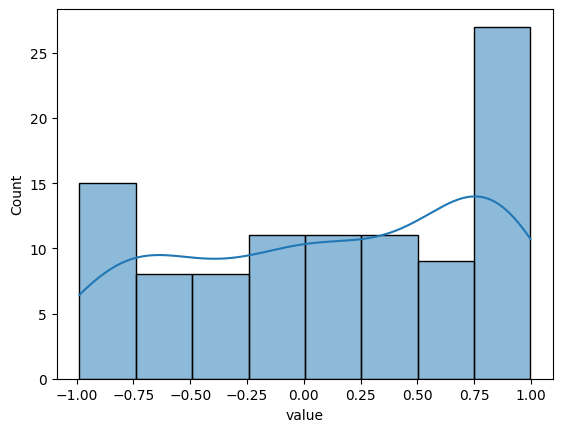

In [ ]:
# @title Visualizing Bayesian Learning Results with Histograms

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load CSV file
df = pd.read_csv('reservoir.csv')
sns.histplot(df['value'], kde=True)
plt.show()

In [ ]:
# @title Kernel density estimation (to avoid overfitting) and hyper-parameter determination

import pandas as pd
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler
import numpy as np

# Importing CSV files
file_path = 'reservoir.csv'
df = pd.read_csv(file_path)

################
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity

# Extract data from 'value' to 'seed_value'
data_columns = ['value', 'lag', 'dim', 'N_x', 'beta', 'density', 'input_scale', 'rho', 'alpha', 'seed_value','bias_scale']
data_optuna = df[data_columns]

# Data standardization (scaling)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_optuna)

# Weight list (set weights for each parameter)
weights = np.array([3, 4, 4, 0.5,1.0, 1.0, 1.0, 1.0, 1.0, 0.1,1.0])

#Experimentally, implementation of optuna, lag and dim will (roughly) converge, so we want to keep the weights of that pair large
#We would like a learning result that does not depend on seed_value
#Since we want to figure hyperparametes out that ``value" is stable, so we take its weight rather large

# Apply Weights
weighted_data = scaled_data * weights

# Kernel density estimation
kde = KernelDensity(kernel='gaussian', bandwidth=1.0).fit(weighted_data)

# Calculate the log density of each data point
log_density = kde.score_samples(weighted_data)

# Apply Threshold
threshold = 0.0
filtered_df = df[df['value'] >= threshold]
filtered_log_density = log_density[df['value'] >= threshold]

# Find the point of highest density
max_density_index = np.argmax(filtered_log_density)
max_density_point = filtered_df.iloc[max_density_index]

# Outputs the densest data points
print("The point with the highest density is:")
print(max_density_point)


# Decisive Reservoir hyperparameters
lag = int(max_density_point[1])
dim = int(max_density_point[2])
N_x = int(max_density_point[3])
beta = max_density_point[4]
density =max_density_point[5]
input_scale = max_density_point[6]
rho = max_density_point[7]
alpha = max_density_point[8]
seed_value =max_density_point[9]
bias_scale =max_density_point[10]

print(f"Parameter Determination:")
print(f"lag: {lag}")
print(f"dim: {dim}")
print(f"N_x: {N_x}")
print(f"beta: {beta}")
print(f"density: {density}")
print(f"input_scale: {input_scale}")
print(f"rho: {rho}")
print(f"alpha: {alpha}")
print(f"seed_value: {seed_value}")
print(f"bias_scale: {bias_scale}")

The point with the highest density is:
value           0.912257
lag             9.000000
dim             5.000000
N_x            70.000000
beta            0.010000
density         0.621506
input_scale     0.363794
rho             0.682525
alpha           0.655029
seed_value     53.911953
bias_scale     -0.022580
Name: 48, dtype: float64
Parameter Determination:
lag: 9
dim: 5
N_x: 70
beta: 0.01
density: 0.62150557418972
input_scale: 0.3637940887606374
rho: 0.6825250424377878
alpha: 0.6550294232399878
seed_value: 53.91195296745694
bias_scale: -0.0225798448581879


<ipython-input-8-92e00e7c50fe>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lag = int(max_density_point[1])
<ipython-input-8-92e00e7c50fe>:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dim = int(max_density_point[2])
<ipython-input-8-92e00e7c50fe>:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  N_x = int(max_density_point[3])
<ipython-input-8-92e00e7c50fe>:58: FutureWarning: Series.__getitem__ treating keys as positions i

In [ ]:
# @title Hyperparameters: model evaluation

test_num    = 200               # Estimated number of times for a single test (calculate one PCC)
                                # We regard real data as a non-autonomous system, so not to predict too far into the future
discard_len = 10                # Number of steps at the beginning not learned
T_slide     = T_test+test_num   # The test start time is shifted by making it like T_test+test_num
                                # We do not want to make predictions too far into the future

T_fix       = 150               # Initial time of prediction to be visualized: T_0+T_fix
                                # Can set the time between T_0 and T_0+T_test-1


Correlation coefficient with original data: 0.8424798104472173
forecast period: 100


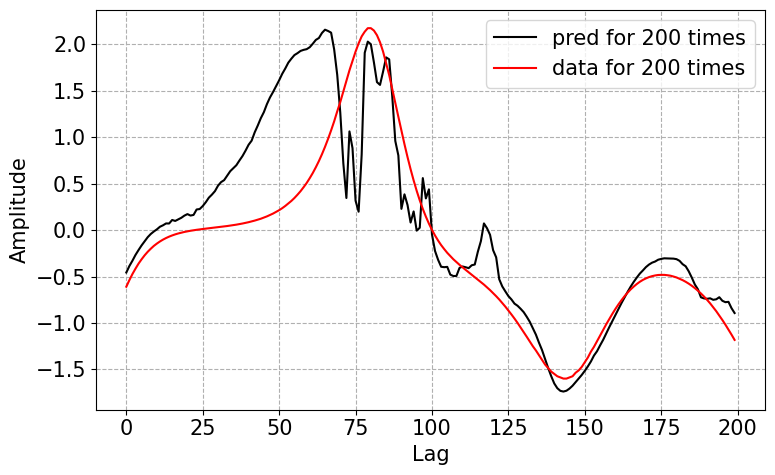

Correlation coefficient with original data: 0.8424798104472173
forecast period: 100


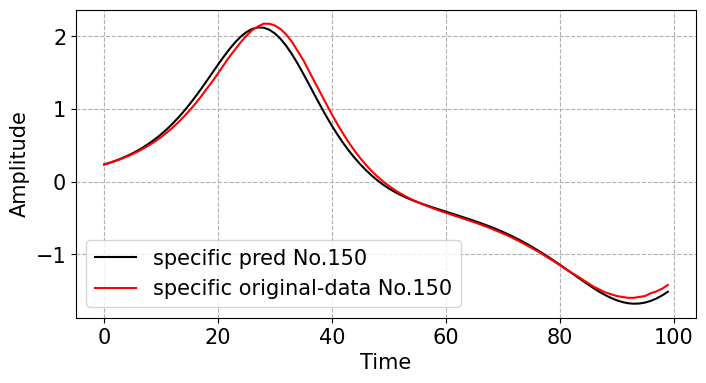

CPU times: user 22.4 s, sys: 14.5 s, total: 36.9 s
Wall time: 23.9 s


In [ ]:
# @title Implementation of Model Evaluation

%%time

###############################
#The test start time

T_0 = T_train+lag*dim+T_slide
###############################
#Generate Win and W again

Win= input_matrix(N_x,seed_value,input_scale,dim)
W = recurrent_matrix(N_x, density, rho,seed_value)

data_delay_train = np.zeros((T_train+1,dim,test_num), dtype=float)
data_delay = np.zeros((T_train+T_test+1,dim,test_num), dtype=float)
test_Y = np.zeros((T_test,test_num))
test_D = np.zeros((T_test,test_num))
tentative_test_Y=np.zeros((T_test,dim,test_num))

###############################################
#Convert test data to a delay coordinate system
for t in range(test_num):

    for i in range(dim):

          data_delay_train[:,i,t] = data[T_0-T_train-i*lag+t:T_0-i*lag+1+t] # i*lag step delayed time series


# Initialization of training data

    train_U = np.zeros((T_train,dim), dtype=float)
    train_D = np.zeros((T_train,dim), dtype=float)

#Input/output of training data

    train_U = data_delay_train[:T_train,:,t]
    train_D = data_delay_train[1:T_train+1,:,t]

##The last time data of the training data output must overlap with the test data!

#Ridge
    X_XT = np.zeros((N_x, N_x))
    D_XT = np.zeros((dim, N_x))
    x_special = np.zeros(N_x)

    X_XT, D_XT,x_special = train(train_U,train_D,np.zeros(N_x),T_train, Win, W, N_x, dim, alpha,discard_len,bias_scale)

#Generate output weight matrix
    Wout= None
    Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)


#####################################################
#Convert predictive data to a delay coordinate system

    for i in range(dim):

           data_delay[:,i,t] = data[T_0+t-T_train-i*lag
                                        :T_0+t+T_test-i*lag+1] # i*lag step delayed time series



  #Predictive data generation

    tentative_test_Y[:,:,t] = run(data_delay[T_train:,:,t],x_special,Win,W,Wout,alpha,T_test,bias_scale)
    test_Y[:,t] = tentative_test_Y[:,0,t]
    test_D[:,t] = data_delay[T_train+1
                             :T_train+T_test+1,0,t]


############################################
#Preparation for calculating autocorrelation

test_Y_cor = [0]*test_num
data_delay_cor = [0]*test_num



for t in range(test_num):

    test_Y_cor[t] = test_Y[T_test-1,t]
    data_delay_cor[t] = test_D[T_test-1,t]


# Calculate the autocorrelation coefficient

ac_flt = correlation(test_Y_cor[:],data_delay_cor[:])



######################
######################

print("Correlation coefficient with original data:", ac_flt)
print("forecast period:", T_test)

fig = plt.figure(figsize=(8,5), dpi=100)
plt.rcParams["font.size"] = 15
plt.grid(which='major', linestyle='--', axis='both')
plt.xlabel("Lag")
plt.ylabel("Amplitude")
plt.plot(test_Y_cor[:], color="black", label=f"pred for {test_num} times")
plt.plot(data_delay_cor[:], color = "red",label=f"data for {test_num} times")
plt.legend()#loc='lower right')
plt.tight_layout()
plt.show()

print("Correlation coefficient with original data:",ac_flt)
print("forecast period:", T_test)



# Running Test Predictions
plt.figure(figsize=(8, 4))
plt.plot(test_Y[:,T_fix], color = "black",label=f"specific pred No.{T_fix}")
plt.plot(test_D[:,T_fix], color = "red",label=f"specific original-data No.{T_fix}")
plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')

plt.show()